# Robots Limpiadores

En un espacio representado por una cuadrícula de tamaño NxN, cada celda puede estar limpia o sucia. En este entorno, operan varias barredoras eléctricas, que son agentes autónomos responsables de limpiar la cuadrícula. Estas barredoras pueden moverse en las ocho direcciones cardinales: arriba, abajo, izquierda, derecha y las cuatro diagonales.

Cada barredora tiene las siguientes capacidades:
* **Detección:** Puede detectar si la celda donde está limpia o sucia.
* **Limpieza:** Puede limpiar la celda en la que se encuentra.
* **Movimiento:** Puede moverse a una celda adyacente si esta no está ocupada por otra barredora.
* **Posición de arranque:** Todas las celdas en posiciones al azar.

El desafío es desarrollar un sistema multiagentes que limpie la cuadrícula de la manera más eficiente posible. Definimos eficiencia como la relación entre el número de celdas limpiadas y el número de celdas recorridas por un agente.

In [2]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen de forma aleatoria.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [3]:
class RobotSweep(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cells_cleaned = 0
        self.cells_visited = 1

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        options = np.random.permutation(len(possible_positions))
        
        for i in options:
            position = possible_positions[i]
            if self.model.grid.is_cell_empty(position):
                self.model.grid.move_agent(self, position)
                self.cells_visited += 1
                break

    def step(self):
        (x, y) = self.pos
        if self.model.cells[x][y] == 1:
            self.model.cells[x][y] = 0
            self.cells_cleaned += 1
        else:
            self.move()

In [4]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 2
    return grid

In [5]:
class RobotSweepModel(Model):
    def __init__(self, width=20, height=20, agents=5, percentage_dirty_cells=10):
        super().__init__()

        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Grid":get_grid, 
                             "Steps":lambda model : model.steps,
                             "Clean":lambda model : 1 - (model.cells.sum() / model.cells.size)},
            agent_reporters={"Efficiency":lambda agent : agent.cells_cleaned / agent.cells_visited})

        self.cells = np.zeros( (width, height) )
        count = int( (width * height * (percentage_dirty_cells / 100) ) )
        while (count > 0):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 1
                count -= 1 
        
        self.steps = 0

        i = 0
        while (i < agents):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.grid.is_cell_empty( (x, y) ):
                agent = RobotSweep(self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                i += 1

    def step(self):
        #if not(self.is_all_clean()):
        #    self.steps += 1
        self.datacollector.collect(self)
        self.schedule.step()

    def is_all_clean(self):
        return (self.cells.sum() == 0)

In [6]:
# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = RobotSweepModel()
while not(model.is_all_clean()):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

/tmp/ipykernel_7186/276033220.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


Tiempo de ejecución: 0:00:00.208133


In [7]:
all_agents_info = model.datacollector.get_agent_vars_dataframe()
all_agents_info.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4170 entries, (1, 1) to (834, 3)
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Efficiency  4170 non-null   float64
dtypes: float64(1)
memory usage: 83.9 KB


In [8]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Grid    834 non-null    object 
 1   Steps   834 non-null    int64  
 2   Clean   834 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 19.7+ KB


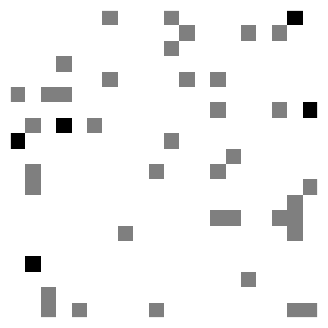

In [10]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0, 0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grids.iloc[i, 0])
    
anim = animation.FuncAnimation(fig, animate, frames=model.steps)

In [13]:
anim

In [28]:
params = {"width":20, "height":20, "agents":range(5, 25, 5), "percentage_dirty_cells":10}

MAX_SIMULATIONS = 10
MAX_ITERATIONS = 1000

results = batch_run(
    RobotSweepModel,
    parameters=params,
    iterations=MAX_SIMULATIONS,
    max_steps=MAX_ITERATIONS,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7186/276033220.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [29]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500040 entries, 0 to 500039
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   RunId                   500040 non-null  int64  
 1   iteration               500040 non-null  int64  
 2   Step                    500040 non-null  int64  
 3   width                   500040 non-null  int64  
 4   height                  500040 non-null  int64  
 5   agents                  500040 non-null  int64  
 6   percentage_dirty_cells  500040 non-null  int64  
 7   Grid                    500040 non-null  object 
 8   Steps                   500040 non-null  int64  
 9   Clean                   500040 non-null  float64
 10  AgentID                 500000 non-null  float64
 11  Efficiency              500000 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 45.8+ MB


In [30]:
average_steps_per_runid = df.groupby('RunId')['Steps'].mean().reset_index()
print(average_steps_per_runid)

    RunId       Steps
0       0  501.399920
1       1  501.449955
2       2  501.466636
3       3  501.474976
4       4  501.399920
5       5  501.449955
6       6  501.466636
7       7  501.474976
8       8  501.399920
9       9  501.449955
10     10  501.466636
11     11  501.474976
12     12  501.399920
13     13  501.449955
14     14  501.466636
15     15  501.474976
16     16  501.399920
17     17  501.449955
18     18  501.466636
19     19  501.474976
20     20  501.399920
21     21  501.449955
22     22  501.466636
23     23  501.474976
24     24  501.399920
25     25  501.449955
26     26  501.466636
27     27  501.474976
28     28  501.399920
29     29  501.449955
30     30  501.466636
31     31  501.474976
32     32  501.399920
33     33  501.449955
34     34  501.466636
35     35  501.474976
36     36  501.399920
37     37  501.449955
38     38  501.466636
39     39  501.474976


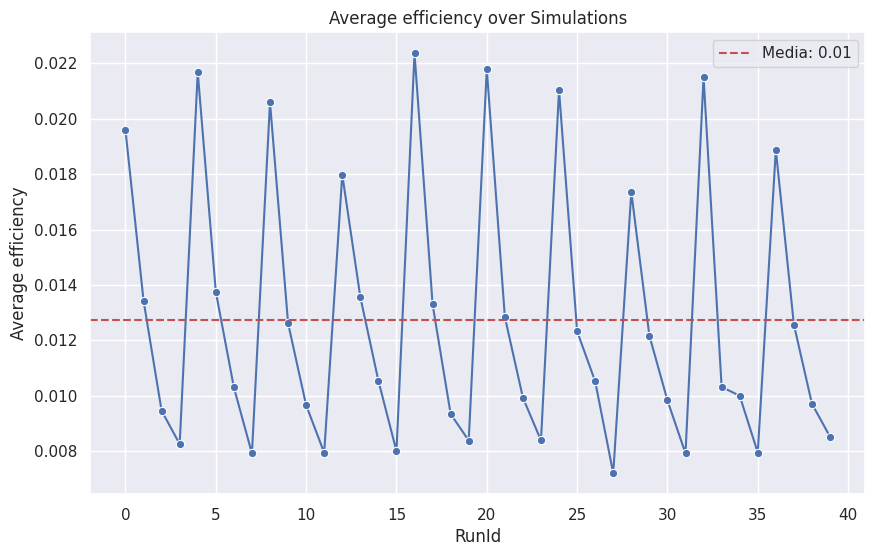

In [31]:
# Agrupamos por RunId y calculamos el promedio de Efficiency para cada grupo
efficiency_avg_by_runid = df.groupby('RunId')['Efficiency'].mean().reset_index()

# Calculamos la media de todos los promedios de Efficiency
mean_efficiency_avg = efficiency_avg_by_runid['Efficiency'].mean()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(x='RunId', y='Efficiency', data=efficiency_avg_by_runid, marker='o')

# Añadimos una línea horizontal para marcar la media
plt.axhline(mean_efficiency_avg, color='r', linestyle='--', label=f'Media: {mean_efficiency_avg:.2f}')

# Añadimos etiquetas y título
plt.xlabel('RunId')
plt.ylabel('Average efficiency')
plt.title("Average efficiency over Simulations")
plt.legend()
plt.show()

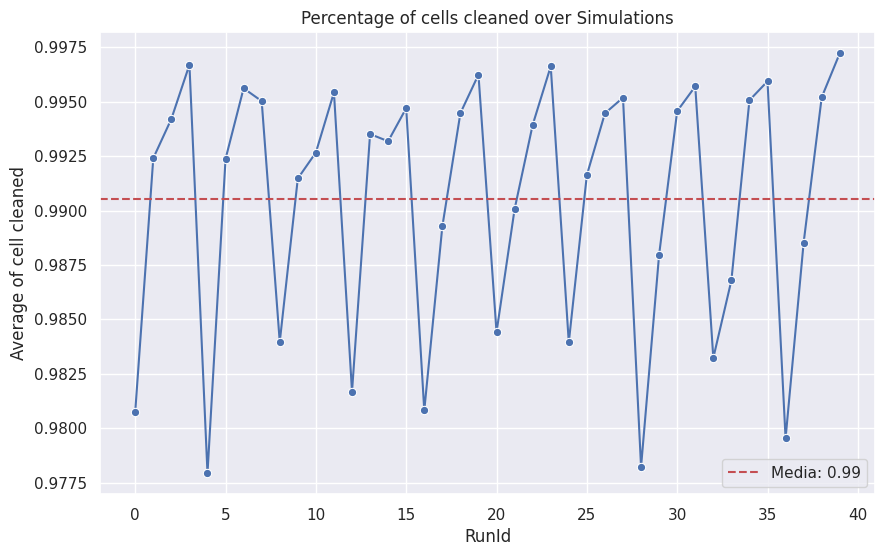

In [32]:
# Agrupamos por RunId y calculamos el promedio de Clean para cada grupo
clean_avg_by_runid = df.groupby('RunId')['Clean'].mean().reset_index()

# Calculamos la media de todos los promedios de Clean
mean_clean_avg = clean_avg_by_runid['Clean'].mean()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(x='RunId', y='Clean', data=clean_avg_by_runid, marker='o')

# Añadimos una línea horizontal para marcar la media
plt.axhline(mean_clean_avg, color='r', linestyle='--', label=f'Media: {mean_clean_avg:.2f}')

# Añadimos etiquetas y título
plt.xlabel('RunId')
plt.ylabel('Average of cell cleaned')
plt.title('Percentage of cells cleaned over Simulations')
plt.legend()
plt.show()

In [34]:
average_efficiency_by_agents = df.groupby('agents')['Efficiency'].mean()
print(average_efficiency_by_agents)

agents
5     0.020277
10    0.012690
15    0.009929
20    0.008047
Name: Efficiency, dtype: float64
